## DeepCycle
### In this notebook we explore BF performance only.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# curated_tracks - cell tracks syncronized on 1 division events
# double_division_tracks - cell tracks syncronized on 2 division events
from const import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
from numpy import savez_compressed, load
import pandas as pd
import cv2
import sompy
from scipy.interpolate import interp1d

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')

from notebook_functions import umap_transform, plot_distributions, correlation_plot,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

Accuracy: 0.6416487234697016
[[0.74850432 0.00598272 0.18701529 0.05849767]
 [0.44835681 0.00234742 0.45187793 0.09741784]
 [0.20754233 0.00410467 0.72755259 0.06080041]
 [0.30204082 0.00204082 0.61020408 0.08571429]]


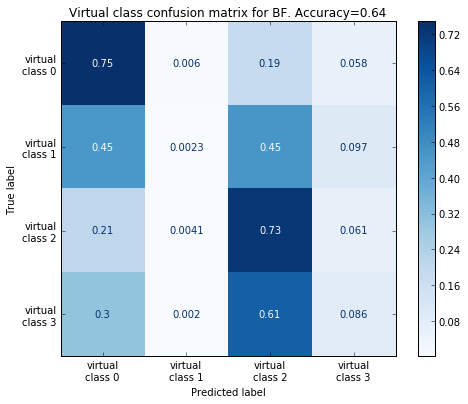

In [2]:
# load cell descriptors where 
# y - true class [1..4] one hot encoded, 
# descriptors - 4-component vectors, 
# intensities - 2-component intensities of the cell

with open(DATA_ROOT / 'descriptors.r34.sz48.BF.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)

y_pred = np.argmax(descriptors, axis=1)
y_true = np.argmax(y, axis=1)
classes = sorted(np.unique(y_true))

acc = (y_pred == y_true).sum() / len(y_pred)
print('Accuracy:', acc)

confusion_mx = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize='true')
print(confusion_mx)

nl = '\n'
disp = ConfusionMatrixDisplay(confusion_mx, [f'virtual{nl}class {c}' for c in classes])
disp.plot(cmap='Blues')
fig = plt.gcf()
fig.set_size_inches(8, 6)
disp.ax_.set_title(f'Virtual class confusion matrix for BF. Accuracy={acc:.2f}')
fig.savefig('conf_matrix_BF.png', dpi=100)
plt.show()

In [3]:
descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

(9753, 4) (9753, 4) (9753, 2)


## U-Map embedding

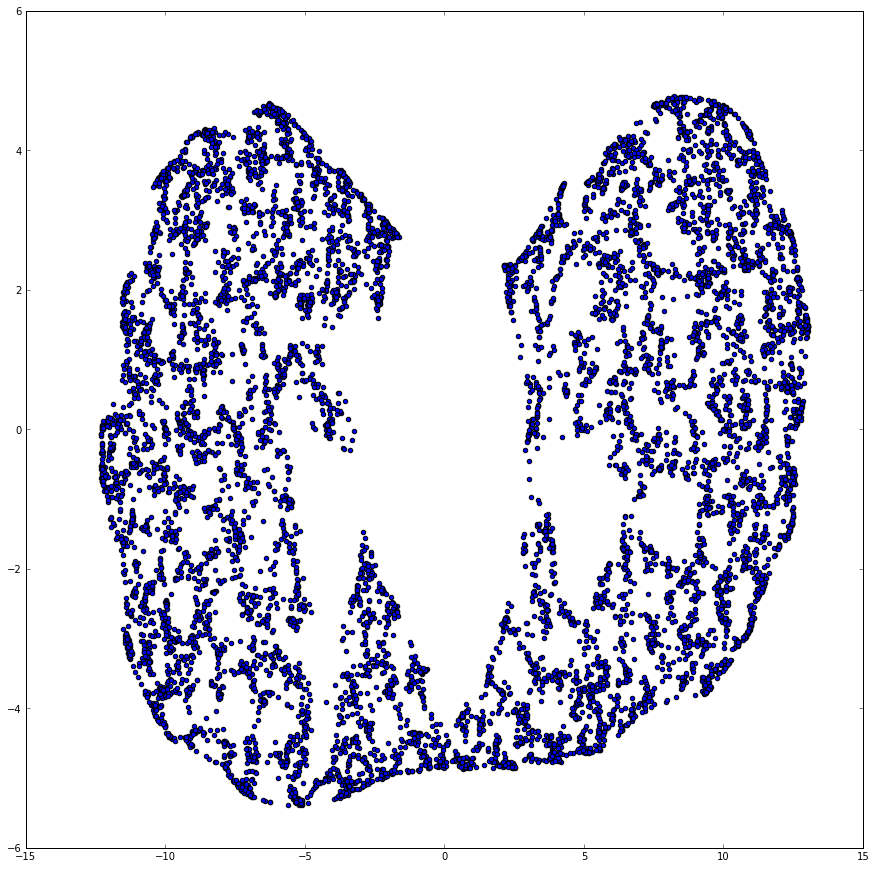

In [4]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=300, min_dist=0.05, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])
plt.show()

## Finding average track with SOM clustering

In [17]:
mapsize = 30
som = sompy.SOMFactory.build(embeddings_preds, mapsize, mask=None, mapshape='cylinder', lattice='rect',
                             normalization='None', initialization='spherical', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix
som_bmu = som._bmu[0].astype(int)

input was considered as the numbers of nodes
map size is [1,30]


In [18]:
som_translation_tbl = np.roll(sorted(np.unique(som_bmu))[::1], -4)

som_matrix = som_matrix[som_translation_tbl]
som_bmu = som_translation_tbl[som_bmu]

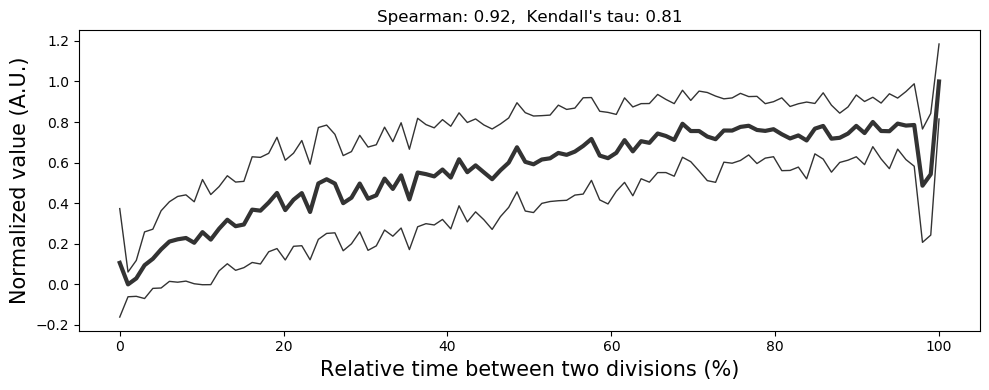

In [19]:
cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
correlation_plot(cell_df, df_index, som_bmu, gfp_key='GFP_20', cy3_key='Cy3_20')

In [22]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)

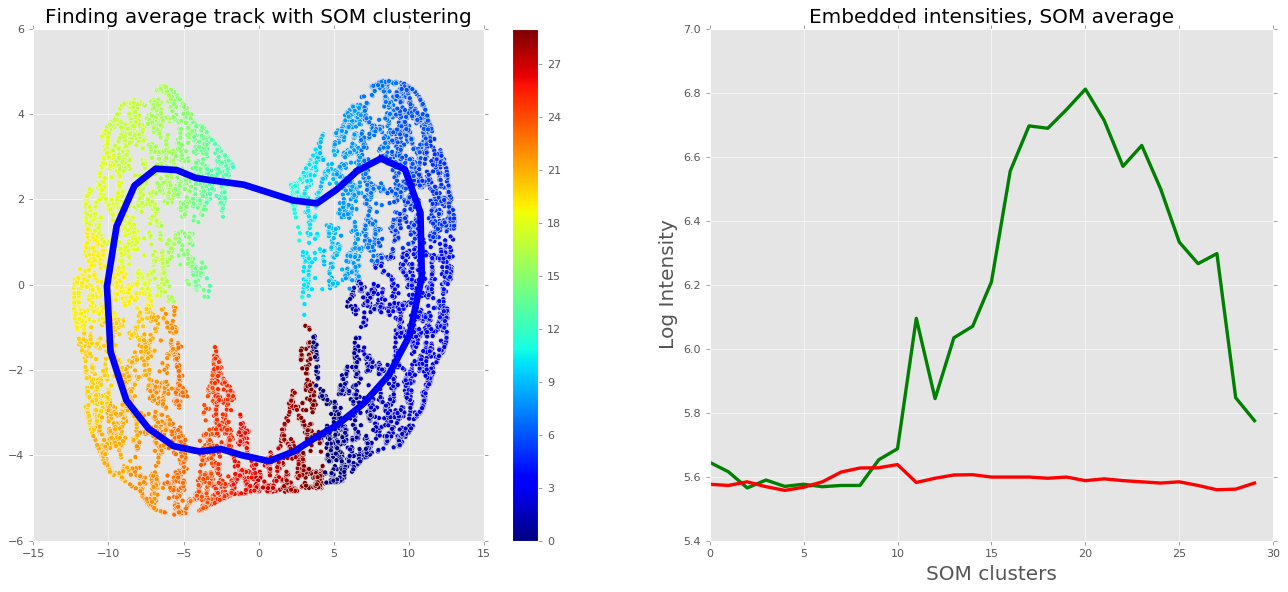

In [23]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track[:, 0], c='green', linewidth=3)
ax2.plot(som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)


plt.show()

# Time reconstruction using unseen data

In [10]:
with open(DATA_ROOT / 'descriptors_all.r34.sz48.BF.pkl', 'rb') as f:
    y_all, descriptors_all, intensities_all, df_index_all = pickle.load(f)
descriptors_all = np.log(descriptors_all + 1e-7)
intensities_all = np.log(intensities_all + log_const)
print(y_all.shape, descriptors_all.shape, intensities_all.shape)

(2684453, 4) (2684453, 4) (2684453, 2)


In [11]:
embeddings_preds_all = fit.transform(descriptors_all[::10])

In [20]:
som_bmu_all = som_translation_tbl[som.project_data(embeddings_preds_all)]

In [24]:
fun = np.median
som_track_all = []
for cluster in np.sort(np.unique(som_bmu_all)):
    som_track_all.append(fun(intensities_all[::10][som_bmu_all == cluster], 0))
som_track_all = np.array(som_track_all)

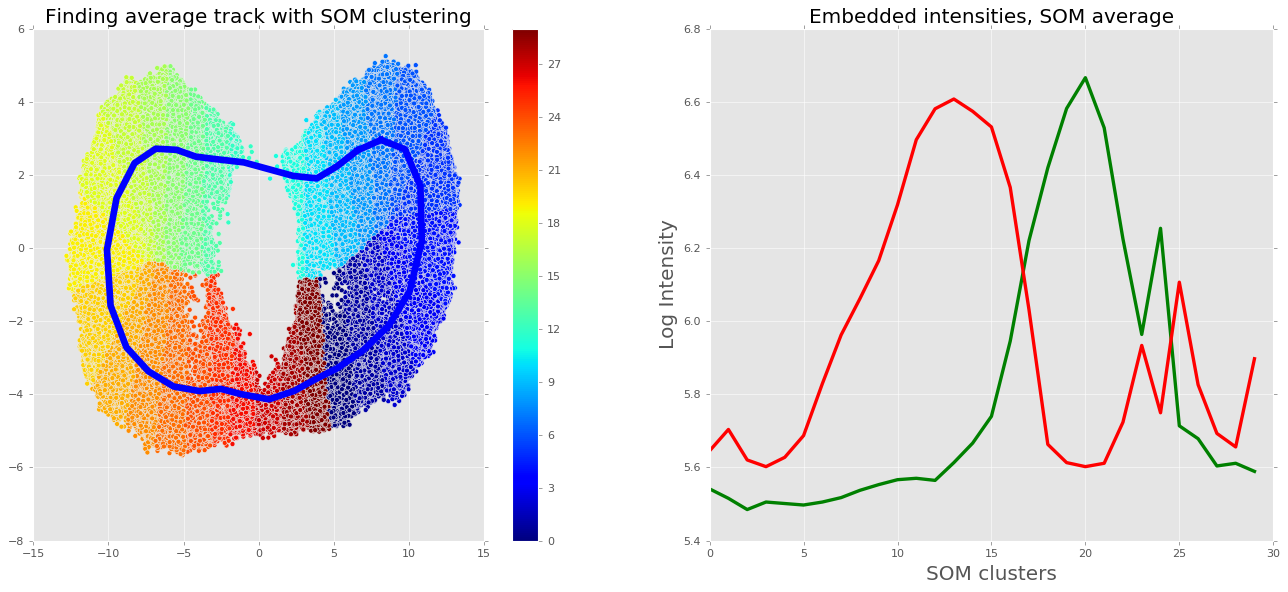

In [25]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track_all[:, 0], c='green', linewidth=3)
ax2.plot(som_track_all[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)

plt.show()

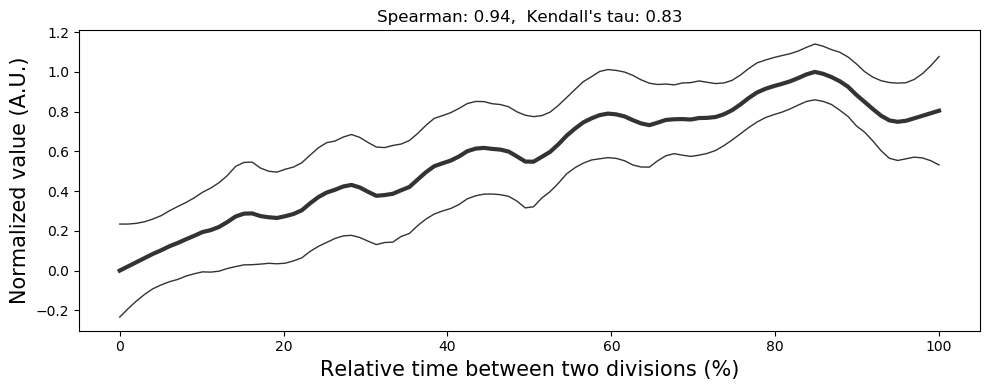

In [26]:
correlation_plot(cell_df.loc[df_index_all[::10].flatten()], df_index_all[::10], som_bmu_all, gfp_key='GFP_20', cy3_key='Cy3_20')